<a href="https://www.kaggle.com/code/hazzai/artificial-aesthete-project?scriptVersionId=136968105" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
from tqdm import tqdm, tqdm_notebook
import random

import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.applications import *
from tensorflow.keras.callbacks import *
from tensorflow.keras.initializers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from numpy.random import seed
seed(1)
import tensorflow
tensorflow.random.set_seed(1)

<font size="5">Reading Data</font>

In [2]:
print(os.listdir("../input/best-artworks-of-all-time"))

['artists.csv', 'resized', 'images']


In [3]:
artists = pd.read_csv('../input/best-artworks-of-all-time/artists.csv')
artists.shape

(50, 8)

<font size="5">Data Processing</font>

In [4]:
# Sort artists by number of paintings
artists = artists.sort_values(by=['paintings'], ascending=False)

# Create a dataframe with artists having more than 200 paintings
artists_top = artists[artists['paintings'] >= 200].reset_index()
artists_top = artists_top[['name', 'paintings']]

artists_top['class_weight'] = artists_top.paintings.sum() / (artists_top.shape[0] * artists_top.paintings)
artists_top

,name,paintings,class_weight
0,Vincent van Gogh,877,0.445631
1,Edgar Degas,702,0.556721
2,Pablo Picasso,439,0.890246
3,Pierre-Auguste Renoir,336,1.163149
4,Albrecht Dürer,328,1.191519
5,Paul Gauguin,311,1.256650
6,Francisco Goya,291,1.343018
7,Rembrandt,262,1.491672
8,Alfred Sisley,259,1.508951
9,Titian,255,1.532620


In [5]:
# Set class weights - assign higher weights to underrepresented classes
class_weights = artists_top['class_weight'].to_dict()
class_weights

{0: 0.44563076604125634,
 1: 0.5567210567210568,
 2: 0.8902464278318493,
 3: 1.1631493506493507,
 4: 1.1915188470066518,
 5: 1.2566501023092662,
 6: 1.3430178069353327,
 7: 1.491672449687717,
 8: 1.5089505089505089,
 9: 1.532620320855615,
 10: 1.6352225180677062}

In [6]:
# There is some problem recognizing 'Albrecht_Dürer'
updated_name = "Albrecht_Dürer".replace("_", " ")
artists_top.iloc[4, 0] = updated_name

In [7]:
# Explore images of top artists
images_dir = '../input/best-artworks-of-all-time/images/images'
artists_dirs = os.listdir(images_dir)
artists_top_name = artists_top['name'].str.replace(' ', '_').values

# See if all directories exist
for name in artists_top_name:
    if os.path.exists(os.path.join(images_dir, name)):
        print("Found -->", os.path.join(images_dir, name))
    else:
        print("Did not find -->", os.path.join(images_dir, name))

Found --> ../input/best-artworks-of-all-time/images/images/Vincent_van_Gogh
Found --> ../input/best-artworks-of-all-time/images/images/Edgar_Degas
Found --> ../input/best-artworks-of-all-time/images/images/Pablo_Picasso
Found --> ../input/best-artworks-of-all-time/images/images/Pierre-Auguste_Renoir
Found --> ../input/best-artworks-of-all-time/images/images/Albrecht_Dürer
Found --> ../input/best-artworks-of-all-time/images/images/Paul_Gauguin
Found --> ../input/best-artworks-of-all-time/images/images/Francisco_Goya
Found --> ../input/best-artworks-of-all-time/images/images/Rembrandt
Found --> ../input/best-artworks-of-all-time/images/images/Alfred_Sisley
Found --> ../input/best-artworks-of-all-time/images/images/Titian
Found --> ../input/best-artworks-of-all-time/images/images/Marc_Chagall


<font size="4">print few random paintings</font>

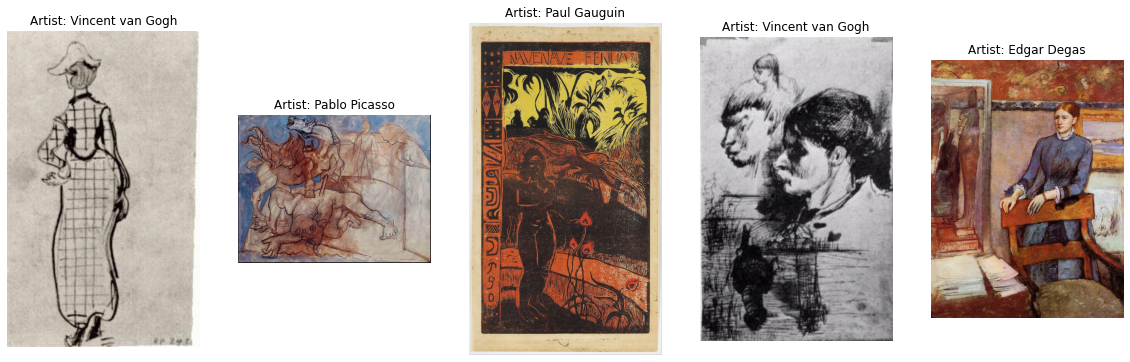

In [8]:
# Print few random paintings
n = 5
fig, axes = plt.subplots(1, n, figsize=(20,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)
    image = plt.imread(random_image_file)
    axes[i].imshow(image)
    axes[i].set_title("Artist: " + random_artist.replace('_', ' '))
    axes[i].axis('off')

plt.show()

<font size="5">Data Augmentation</font>

In [25]:
# Augment data
batch_size = 16
train_input_shape = (224, 224, 3)
n_classes = artists_top.shape[0]

train_datagen = ImageDataGenerator(validation_split=0.2,
                                   rescale=1./255.,
                                   shear_range=5,
                                   horizontal_flip=True,
                                   vertical_flip=True,
                                  )

train_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="training",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

valid_generator = train_datagen.flow_from_directory(directory=images_dir,
                                                    class_mode='categorical',
                                                    target_size=train_input_shape[0:2],
                                                    batch_size=batch_size,
                                                    subset="validation",
                                                    shuffle=True,
                                                    classes=artists_top_name.tolist()
                                                   )

STEP_SIZE_TRAIN = train_generator.n//train_generator.batch_size
STEP_SIZE_VALID = valid_generator.n//valid_generator.batch_size
print("Total number of batches =", STEP_SIZE_TRAIN, "and", STEP_SIZE_VALID)

Found 3444 images belonging to 11 classes.
Found 855 images belonging to 11 classes.
Total number of batches = 215 and 53


<font size="4">Print a random painting and its augmented version</font>

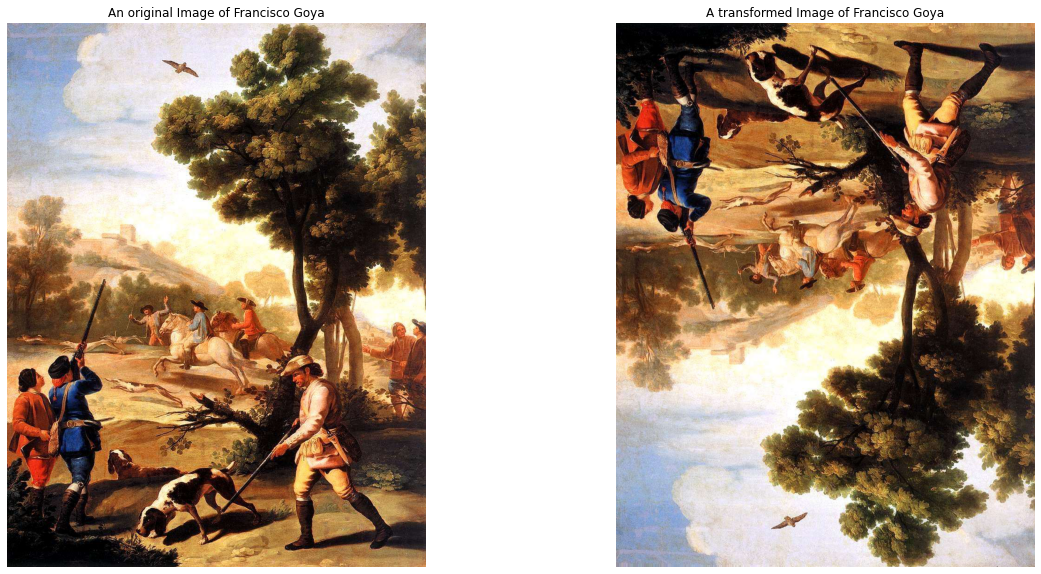

In [26]:
# Print a random paintings and it's random augmented version
fig, axes = plt.subplots(1, 2, figsize=(20,10))

random_artist = random.choice(artists_top_name)
random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
random_image_file = os.path.join(images_dir, random_artist, random_image)

# Original image
image = plt.imread(random_image_file)
axes[0].imshow(image)
axes[0].set_title("An original Image of " + random_artist.replace('_', ' '))
axes[0].axis('off')

# Transformed image
aug_image = train_datagen.random_transform(image)
axes[1].imshow(aug_image)
axes[1].set_title("A transformed Image of " + random_artist.replace('_', ' '))
axes[1].axis('off')

plt.show()

### Build Model

In [27]:
# Load pre-trained model
base_model = ResNet50(include_top=False, weights='imagenet', input_shape=train_input_shape, pooling=max)

for layer in base_model.layers:
    layer.trainable = True

In [28]:
# Add layers at the end
X = base_model.output
X = Flatten()(X)

X = Dense(512, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

X = Dense(16, kernel_initializer='he_uniform')(X)
X = BatchNormalization()(X)
X = Activation('relu')(X)

output = Dense(n_classes, activation='softmax')(X)

model = Model(inputs=base_model.input, outputs=output)

In [29]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

In [30]:
n_epoch = 10

early_stop = EarlyStopping(monitor='val_loss', patience=20, verbose=1, 
                           mode='auto', restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, 
                              verbose=1, mode='auto')

In [31]:
# Train the model - all layers
history1 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
215/215 [==============================] - 127s 541ms/step - loss: 1.5450 - accuracy: 0.5146 - val_loss: 2.4466 - val_accuracy: 0.0165
Epoch 2/10
215/215 [==============================] - 118s 522ms/step - loss: 1.1419 - accuracy: 0.7232 - val_loss: 2.5432 - val_accuracy: 0.0731
Epoch 3/10
215/215 [==============================] - 117s 516ms/step - loss: 0.9917 - accuracy: 0.7812 - val_loss: 2.7149 - val_accuracy: 0.1639
Epoch 4/10
215/215 [==============================] - 118s 522ms/step - loss: 0.8544 - accuracy: 0.8279 - val_loss: 2.3385 - val_accuracy: 0.2759
Epoch 5/10
215/215 [==============================] - 117s 523ms/step - loss: 0.7518 - accuracy: 0.8676 - val_loss: 1.3275 - val_accuracy: 0.6592
Epoch 6/10
215/215 [==============================] - 119s 529ms/step - loss: 0.6715 - accuracy: 0.8778 - val_loss: 0.9366 - val_accuracy: 0.8054
Epoch 7/10
215/215 [==============================] - 116s 519ms/step - loss: 0.5817 - accuracy: 0.9058 - val_loss: 1.0529 -

In [32]:
# Freeze core ResNet layers and train again 
for layer in model.layers:
    layer.trainable = False

for layer in model.layers[25:50]:
    layer.trainable = True

optimizer = Adam(learning_rate=0.0001)

model.compile(loss='categorical_crossentropy',
              optimizer=optimizer, 
              metrics=['accuracy'])

n_epoch = 50
history2 = model.fit_generator(generator=train_generator, steps_per_epoch=STEP_SIZE_TRAIN,
                              validation_data=valid_generator, validation_steps=STEP_SIZE_VALID,
                              epochs=n_epoch,
                              shuffle=True,
                              verbose=1,
                              callbacks=[reduce_lr, early_stop],
                              use_multiprocessing=True,
                              workers=16,
                              class_weight=class_weights
                             )

Epoch 1/50
215/215 [==============================] - 118s 514ms/step - loss: 0.2285 - accuracy: 0.9787 - val_loss: 0.6347 - val_accuracy: 0.8491
Epoch 2/50
215/215 [==============================] - 114s 507ms/step - loss: 0.2037 - accuracy: 0.9822 - val_loss: 0.6131 - val_accuracy: 0.8656
Epoch 3/50
215/215 [==============================] - 114s 508ms/step - loss: 0.1840 - accuracy: 0.9857 - val_loss: 0.6109 - val_accuracy: 0.8608
Epoch 4/50
215/215 [==============================] - 113s 503ms/step - loss: 0.1736 - accuracy: 0.9886 - val_loss: 0.6020 - val_accuracy: 0.8502
Epoch 5/50
215/215 [==============================] - 114s 508ms/step - loss: 0.1696 - accuracy: 0.9872 - val_loss: 0.6074 - val_accuracy: 0.8455
Epoch 6/50
215/215 [==============================] - 115s 508ms/step - loss: 0.1580 - accuracy: 0.9898 - val_loss: 0.5993 - val_accuracy: 0.8514
Epoch 7/50
215/215 [==============================] - 114s 510ms/step - loss: 0.1546 - accuracy: 0.9848 - val_loss: 0.6071 -

### Training Graph

In [33]:
# Merge history1 and history2
history = {}
history['loss'] = history1.history['loss'] + history2.history['loss']
history['accuracy'] = history1.history['accuracy'] + history2.history['accuracy']
history['val_loss'] = history1.history['val_loss'] + history2.history['val_loss']
history['val_accuracy'] = history1.history['val_accuracy'] + history2.history['val_accuracy']
history['lr'] = history1.history['lr'] + history2.history['lr']

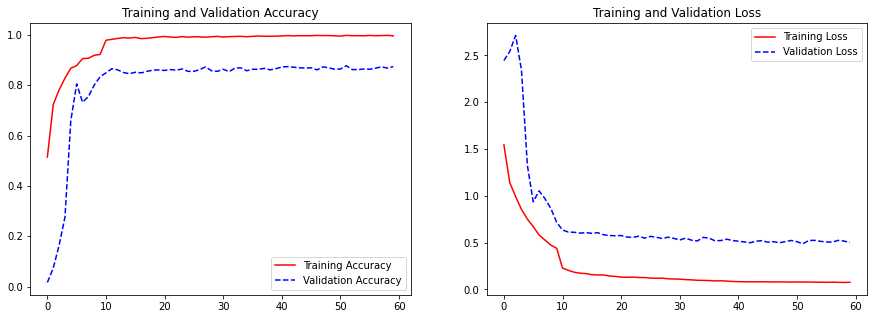

In [34]:
# Plot the training graph
def plot_training(history):
    acc = history['accuracy']
    val_acc = history['val_accuracy']
    loss = history['loss']
    val_loss = history['val_loss']
    epochs = range(len(acc))

    fig, axes = plt.subplots(1, 2, figsize=(15,5))
    
    axes[0].plot(epochs, acc, 'r-', label='Training Accuracy')
    axes[0].plot(epochs, val_acc, 'b--', label='Validation Accuracy')
    axes[0].set_title('Training and Validation Accuracy')
    axes[0].legend(loc='best')

    axes[1].plot(epochs, loss, 'r-', label='Training Loss')
    axes[1].plot(epochs, val_loss, 'b--', label='Validation Loss')
    axes[1].set_title('Training and Validation Loss')
    axes[1].legend(loc='best')
    
    plt.show()
    
plot_training(history)

### Evaluate Performance

In [35]:
# Prediction accuracy on train data
score = model.evaluate_generator(train_generator, verbose=1)
print("Prediction accuracy on train data =", score[1])

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:2006: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


216/216 [==============================] - 98s 454ms/step - loss: 0.0916 - accuracy: 0.9968
Prediction accuracy on train data = 0.9968060255050659


In [36]:
# Prediction accuracy on CV data
score = model.evaluate_generator(valid_generator, verbose=1)
print("Prediction accuracy on CV data =", score[1])

54/54 [==============================] - 23s 434ms/step - loss: 0.5025 - accuracy: 0.8760
Prediction accuracy on CV data = 0.8760234117507935


### Confusion Matrix: Shows what the model thinks the similarity is between artists' techniques

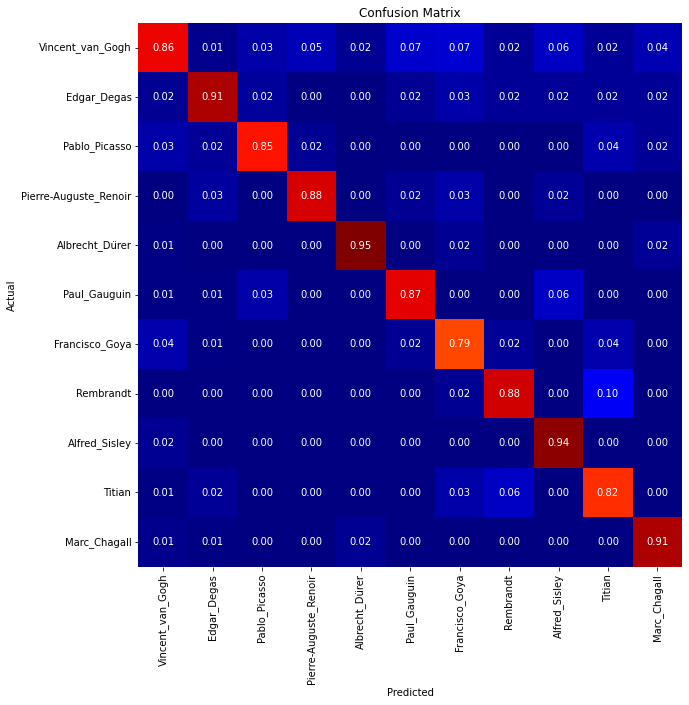

Classification Report:
                       precision    recall  f1-score   support

     Vincent_van_Gogh       0.86      0.86      0.86       174
          Edgar_Degas       0.90      0.91      0.90       140
        Pablo_Picasso       0.90      0.85      0.87        86
Pierre-Auguste_Renoir       0.94      0.88      0.91        66
      Albrecht_Dürer       0.97      0.95      0.96        64
         Paul_Gauguin       0.88      0.87      0.88        61
       Francisco_Goya       0.79      0.79      0.79        58
            Rembrandt       0.88      0.88      0.88        52
        Alfred_Sisley       0.86      0.94      0.90        51
               Titian       0.79      0.82      0.80        50
         Marc_Chagall       0.89      0.91      0.90        46

             accuracy                           0.88       848
            macro avg       0.88      0.88      0.88       848
         weighted avg       0.88      0.88      0.88       848



In [37]:
# Classification report and confusion matrix
from sklearn.metrics import *
import seaborn as sns

tick_labels = artists_top_name.tolist()

def showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID):
    # Loop on each generator batch and predict
    y_pred, y_true = [], []
    for i in range(STEP_SIZE_VALID):
        (X,y) = next(valid_generator)
        y_pred.append(model.predict(X))
        y_true.append(y)
    
    # Create a flat list for y_true and y_pred
    y_pred = [subresult for result in y_pred for subresult in result]
    y_true = [subresult for result in y_true for subresult in result]
    
    # Update Truth vector based on argmax
    y_true = np.argmax(y_true, axis=1)
    y_true = np.asarray(y_true).ravel()
    
    # Update Prediction vector based on argmax
    y_pred = np.argmax(y_pred, axis=1)
    y_pred = np.asarray(y_pred).ravel()
    
    # Confusion Matrix
    fig, ax = plt.subplots(figsize=(10,10))
    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))
    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
    
    print('Classification Report:')
    print(classification_report(y_true, y_pred, labels=np.arange(n_classes), target_names=artists_top_name.tolist()))

showClassficationReport_Generator(model, valid_generator, STEP_SIZE_VALID)

## Evaluate performance by predicting on random images from dataset

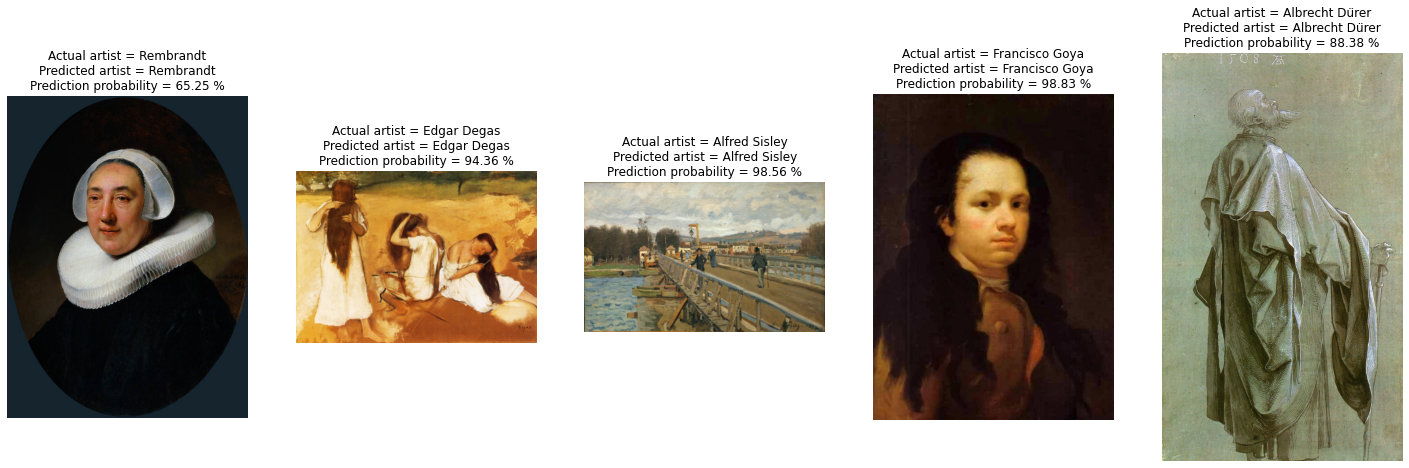

In [38]:
# Prediction
from keras.preprocessing import *

n = 5
fig, axes = plt.subplots(1, n, figsize=(25,10))

for i in range(n):
    random_artist = random.choice(artists_top_name)
    random_image = random.choice(os.listdir(os.path.join(images_dir, random_artist)))
    random_image_file = os.path.join(images_dir, random_artist, random_image)

    # Original image

    test_image = image.load_img(random_image_file, target_size=(train_input_shape[0:2]))

    # Predict artist
    test_image = image.img_to_array(test_image)
    test_image /= 255.
    test_image = np.expand_dims(test_image, axis=0)

    prediction = model.predict(test_image)
    prediction_probability = np.amax(prediction)
    prediction_idx = np.argmax(prediction)

    labels = train_generator.class_indices
    labels = dict((v,k) for k,v in labels.items())

    title = "Actual artist = {}\nPredicted artist = {}\nPrediction probability = {:.2f} %" \
                .format(random_artist.replace('_', ' '), labels[prediction_idx].replace('_', ' '),
                        prediction_probability*100)

    # Print image
    axes[i].imshow(plt.imread(random_image_file))
    axes[i].set_title(title)
    axes[i].axis('off')

plt.show()